# Boosting

In [1]:
# !pip install xgboost

In [3]:
# basic data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# evaluate
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, plot_precision_recall_curve, plot_roc_curve

# models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Data

In [4]:
df_adult= pd.read_csv('adult.csv')
df_adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [5]:
df_adult.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Missing value

In [8]:
# ditandai dengan '?'
df_adult.replace('?', np.nan).isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

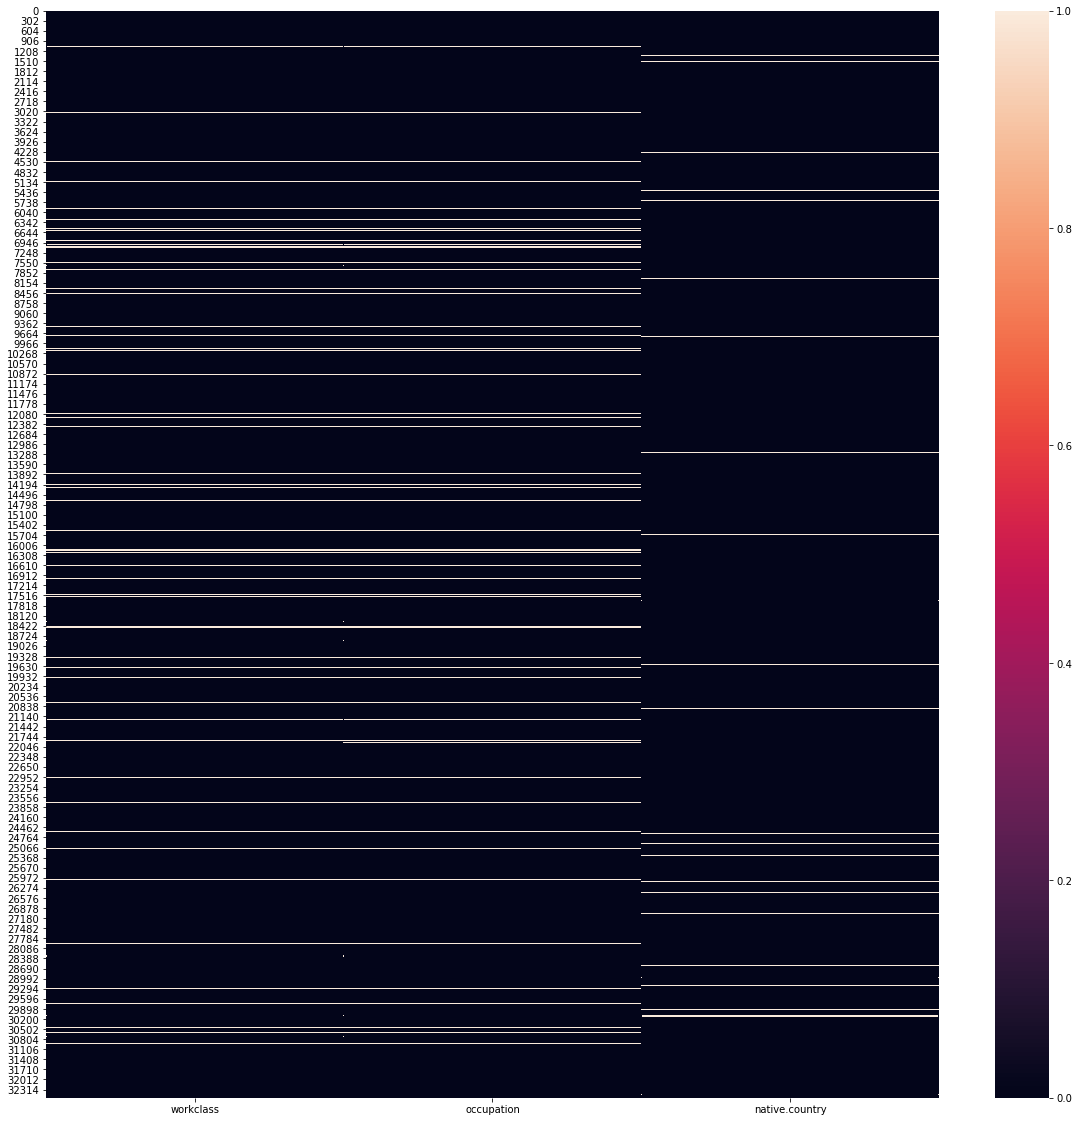

In [10]:

plt.figure(figsize=(20,20))
sns.heatmap(df_adult.replace('?', np.nan)[['workclass','occupation','native.country']].isna())

## Preprocessing

In [11]:
df_adult.describe(include=object)

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


preprocess:  
* missing value : simple imputer with constant  (sudah konstan, ditandai dengan ?)
* one hot encoding : relationship, race, sex  
* binary encoding : workclass, marital status, occupation, native country    
* ordinal encoding : education (already encoded)  
* no treatment : numerical  
* out : fnlwgt  


In [12]:
transformer= ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'),['relationship', 'race','sex']),
    ('binary', ce.BinaryEncoder(),['workclass','marital.status','occupation','native.country'])
], remainder='passthrough')

In [15]:
transformer.fit_transform(df_adult)[0]

array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 90, 77053, 'HS-grad',
       9, 0, 4356, 40, '<=50K'], dtype=object)

## Data splitting

In [17]:
x=df_adult.drop(columns=['fnlwgt','income','education'])
y=np.where(df_adult['income']=='>50K',1,0)

In [20]:
y.sum()

7841

In [21]:
x_train, x_test, y_train, y_test= train_test_split(x,y,
                                                  stratify=y,
                                                  random_state=10)

## Decision Tree

In [22]:
model= DecisionTreeClassifier(max_depth=3)
pipe=Pipeline([
    ('preprocess', transformer),
    ('estimator', model)
])

In [23]:
pipe.fit(x_train,y_train)
y_pred= pipe.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6181
           1       0.68      0.53      0.59      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141



### Model properties

In [30]:
pipe[0].transformers_[0][1].get_feature_names()

array(['x0_Not-in-family', 'x0_Other-relative', 'x0_Own-child',
       'x0_Unmarried', 'x0_Wife', 'x1_Asian-Pac-Islander', 'x1_Black',
       'x1_Other', 'x1_White', 'x2_Male'], dtype=object)

In [34]:
pipe[0].transformers_[1][1].get_feature_names()

['workclass_0',
 'workclass_1',
 'workclass_2',
 'workclass_3',
 'workclass_4',
 'marital.status_0',
 'marital.status_1',
 'marital.status_2',
 'marital.status_3',
 'occupation_0',
 'occupation_1',
 'occupation_2',
 'occupation_3',
 'occupation_4',
 'native.country_0',
 'native.country_1',
 'native.country_2',
 'native.country_3',
 'native.country_4',
 'native.country_5',
 'native.country_6']

In [49]:
x_train.dtypes[x_train.dtypes!=object].index

Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

In [51]:
features=list(pipe[0].transformers_[0][1].get_feature_names())+pipe[0].transformers_[1][1].get_feature_names()+list(x_train.dtypes[x_train.dtypes!=object].index)

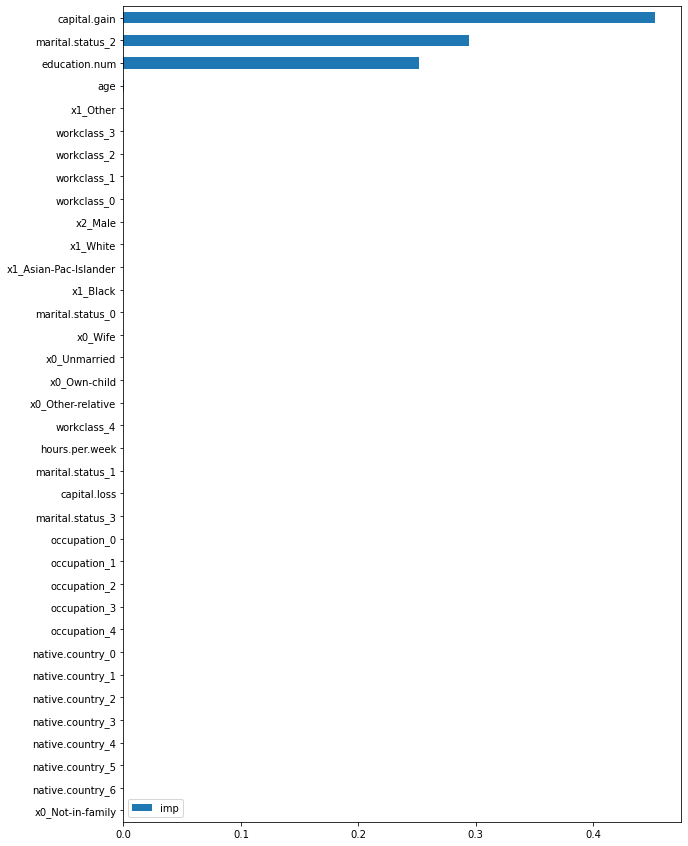

In [56]:
pd.DataFrame({'imp':model.feature_importances_}, index=features).sort_values(by= 'imp').plot(kind='barh', figsize=(10,15))

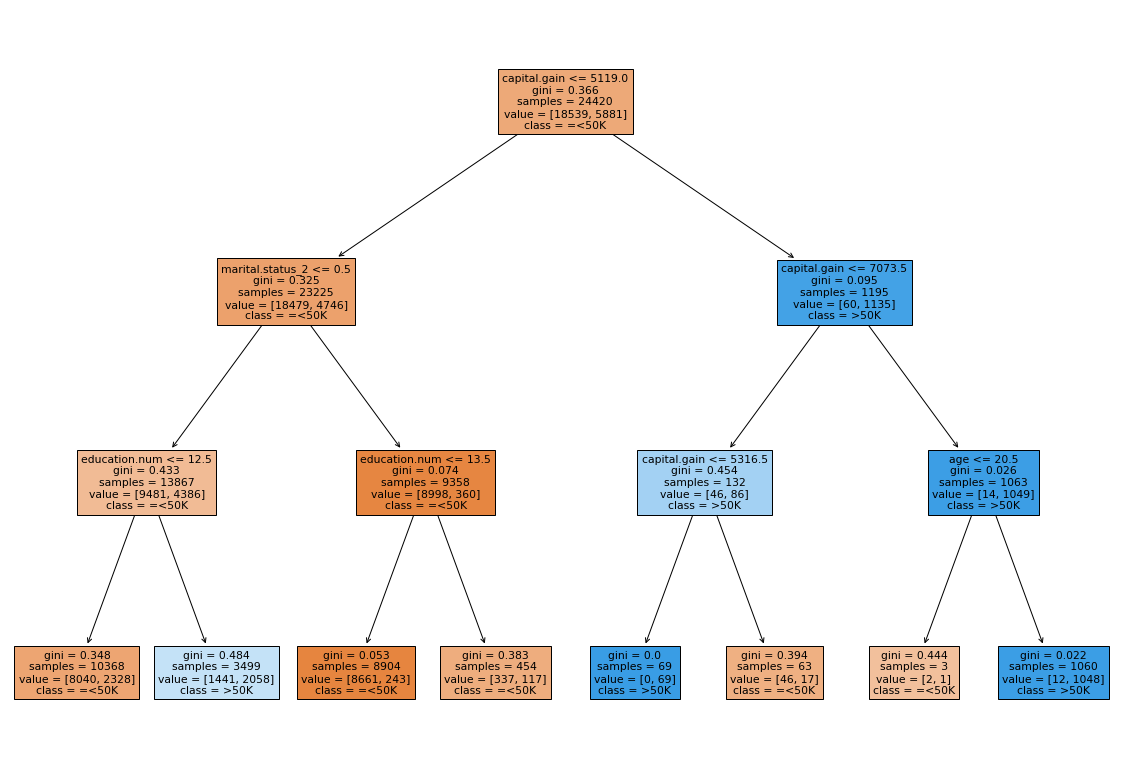

In [58]:
plt.figure(figsize=(20,14))
plot_tree(model, feature_names=features, filled= True, class_names=['=<50K','>50K'])
plt.show()

## Adaptive Boosting

In [59]:
learner= DecisionTreeClassifier(max_depth=3)
model= AdaBoostClassifier(learner, n_estimators=200,learning_rate=0.1, random_state=10)
pipe=Pipeline([
    ('preprocessing', transformer),
    ('estimator',model)
])

In [60]:
pipe.fit(x_train,y_train)
y_pred= pipe.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



### Model properties

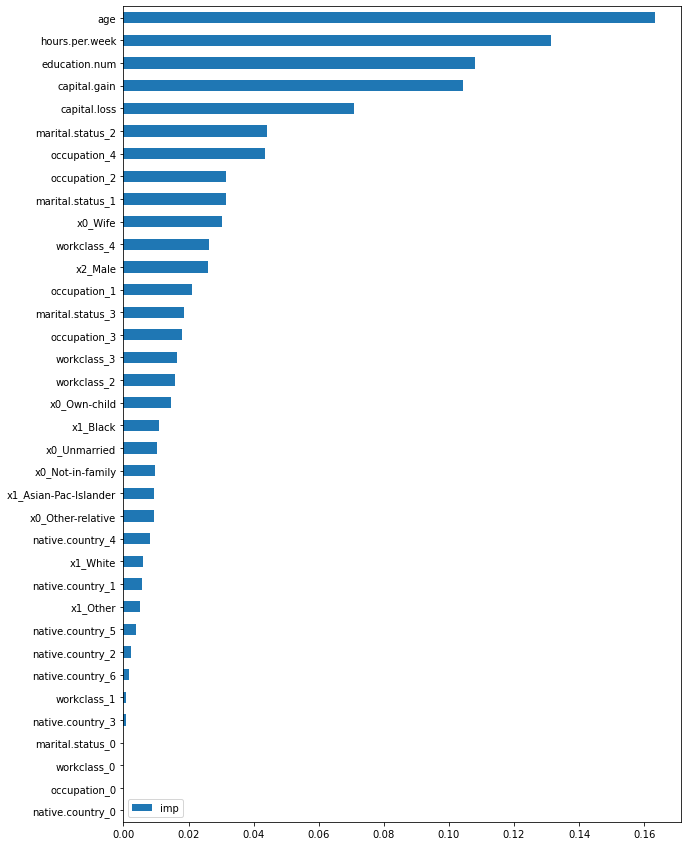

In [62]:
pd.DataFrame({'imp':model.feature_importances_}, index=features).sort_values('imp').plot(kind='barh',figsize=(10,15))

## Gradient Boosting

In [63]:
model= GradientBoostingClassifier(n_estimators=200,
                                 learning_rate=0.1,
                                 max_depth=3,
                                 random_state=10)
pipe=Pipeline([
    ('preprocessing', transformer),
    ('estimator',model)
])

In [64]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



### Model Properties

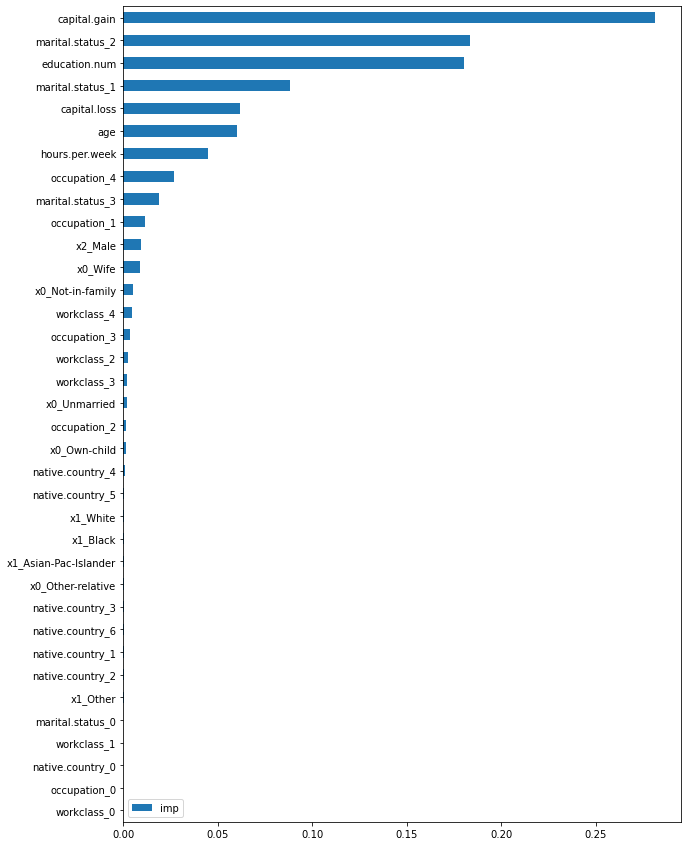

In [65]:
pd.DataFrame({'imp':model.feature_importances_}, index=features).sort_values('imp').plot(kind='barh',figsize=(10,15))

## Extreme Gradient Boosting

In [68]:
model=XGBClassifier(n_estimators=200,
                   learning_rate=0.1,
                   max_depth=3,
                   random_state=10)
pipe=Pipeline([
    ('preprocessing', transformer),
    ('estimator',model)
])

In [69]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)
print(classification_report(y_test,y_pred))

C:\Users\brigi\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



### Model Properties

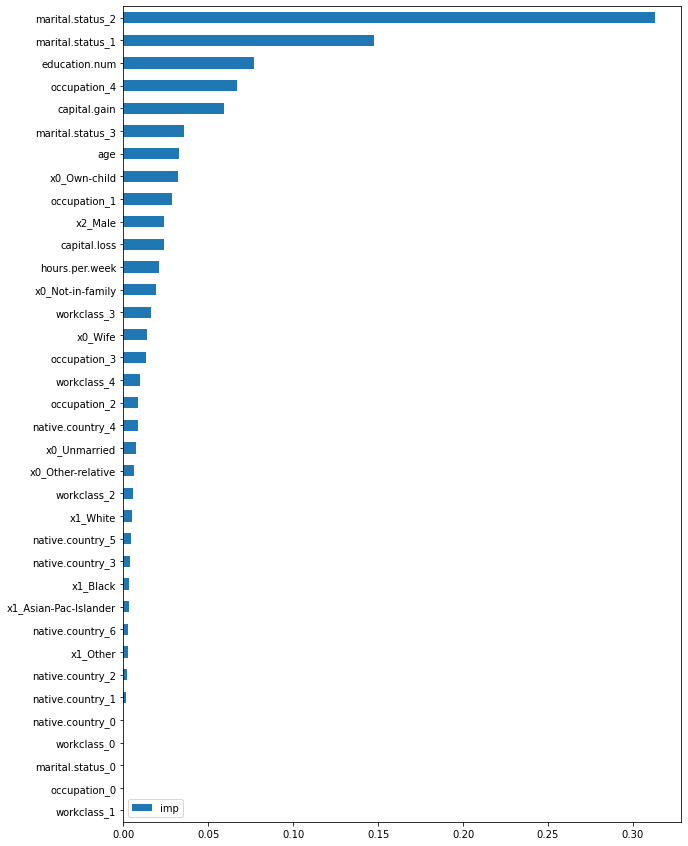

In [71]:
pd.DataFrame({'imp':model.feature_importances_}, index=features).sort_values('imp').plot(kind='barh',figsize=(10,15))

## Model Selection

In [72]:
model_tree= DecisionTreeClassifier(max_depth=3)

model_ada= AdaBoostClassifier(model_tree,
                             n_estimators=200,
                             learning_rate=0.1,
                             random_state=10)
model_gbc= GradientBoostingClassifier(n_estimators=200,
                                     learning_rate=0.1,
                                     max_depth=3,
                                     random_state=10)
model_xgb=XGBClassifier(n_estimators=200,
                         learning_rate=0.1,
                         max_depth=3,
                         random_state=10)

In [73]:
estimator= Pipeline([
    ('preprocess', transformer),
    ('estimator',model_tree)
])

In [74]:
hyperparam_space={
    'estimator':[model_tree,model_ada,model_gbc,model_xgb]
}

In [75]:
skfold= StratifiedKFold(n_splits=5)

grid=GridSearchCV(estimator,
                 param_grid=hyperparam_space,
                 cv=skfold,
                 scoring='f1',
                 n_jobs=-1)

In [76]:
grid.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['workclass',
       

In [78]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.808797,0.071690,0.120870,0.025664,DecisionTreeClassifier(max_depth=3),{'estimator': DecisionTreeClassifier(max_depth...,0.614693,0.595159,0.599240,0.607619,0.611798,0.605702,0.007411,4
1,43.899449,2.453242,0.682167,0.289185,AdaBoostClassifier(base_estimator=DecisionTree...,{'estimator': AdaBoostClassifier(base_estimato...,0.709977,0.706767,0.686821,0.698185,0.726854,0.705721,0.013265,1
2,39.012648,4.735682,0.131179,0.040687,"GradientBoostingClassifier(n_estimators=200, r...",{'estimator': GradientBoostingClassifier(n_est...,0.691218,0.696565,0.682420,0.700765,0.721910,0.698576,0.013179,3
3,23.372150,18.589359,0.062444,0.002599,"XGBClassifier(base_score=None, booster=None, c...","{'estimator': XGBClassifier(base_score=None, b...",0.699719,0.696565,0.679924,0.696154,0.722015,0.698875,0.013476,2


In [79]:
print(grid.best_params_)
grid.best_score_


{'estimator': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)}


0.7057207928319411

In [80]:
grid.best_estimator_.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary', BinaryEncoder(),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupation',
                                                   'native.country'])])),
                ('estimator',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.1, n_estimators=200,
                                    random_state=10))])

In [81]:
print(classification_report(y_test, grid.best_estimator_.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



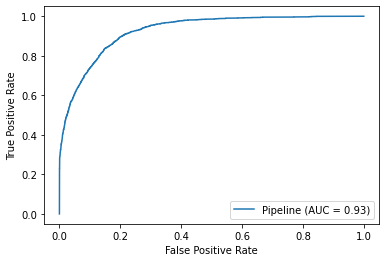

In [82]:
plot_roc_curve(grid.best_estimator_,x_test,y_test)

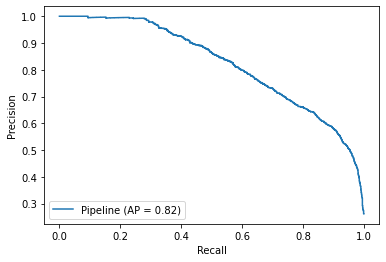

In [83]:
plot_precision_recall_curve(grid.best_estimator_, x_test,y_test)

## Hyperparameter tunning

In [84]:
model_tree= DecisionTreeClassifier(max_depth=3)
model_ada= AdaBoostClassifier(model_tree,
                             n_estimators=200,
                             learning_rate=0.1, 
                              random_state=10)
estimator= Pipeline([
    ('preprocess', transformer),
    ('estimator', model_ada)
])

In [92]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'estimator', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__one hot', 'preprocess__binary', 'preprocess__one hot__categories', 'preprocess__one hot__drop', 'preprocess__one hot__dtype', 'preprocess__one hot__handle_unknown', 'preprocess__one hot__sparse', 'preprocess__binary__cols', 'preprocess__binary__drop_invariant', 'preprocess__binary__handle_missing', 'preprocess__binary__handle_unknown', 'preprocess__binary__mapping', 'preprocess__binary__return_df', 'preprocess__binary__verbose', 'estimator__algorithm', 'estimator__base_estimator__ccp_alpha', 'estimator__base_estimator__class_weight', 'estimator__base_estimator__criterion', 'estimator__base_estimator__max_depth', 'estimator__base_estimator__max_features', 'estimator__base_estimator__max_leaf_nodes', 'estimator__base_estimator__min_impurity_decre

In [88]:
hyperparam_space=[
    {'estimator__learning_rate':[0.1],'estimator__n_estimators':[200],'estimator__base_estimator__max_depth':[3,4,5]}, 
    {'estimator__learning_rate':[0.05],'estimator__n_estimators':[400],'estimator__base_estimator__max_depth':[3,4,5]},
    {'estimator__learning_rate':[0.01],'estimator__n_estimators':[2000],'estimator__base_estimator__max_depth':[3,4,5]},
    {'estimator__learning_rate':[0.005],'estimator__n_estimators':[4000],'estimator__base_estimator__max_depth':[3,4,5]}
]

In [90]:
skfold= StratifiedKFold(n_splits=5)
grid_ada= GridSearchCV(estimator,
                      param_grid=hyperparam_space,
                      cv=skfold,
                       scoring='f1',
                       n_jobs=-1)

In [91]:
grid_ada.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['workclass',
       

In [93]:
print('best score', grid_ada.best_score_)
print('best param', grid_ada.best_params_)

best score 0.7073718800454054
best param {'estimator__base_estimator__max_depth': 4, 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 200}


In [94]:
grid_ada.best_estimator_.fit(x_train,y_train)
y_pred=grid_ada.best_estimator_.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.77      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



Performa model tidak meningkat setelah tunning

Latihan:   
* https://www.kaggle.com/jessemostipak/hotel-booking-demand    
* https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists  
* https://www.kaggle.com/blastchar/telco-customer-churn

Pilih salah satu dari dataset di atas:  
* Lakukan EDA singkat sebagai basis dari skema preprocessing kalian  
* Tentukan metric evaluasi sesuai dengan tujuan bisnis kalian. 
* Pilih model terbaik dari model klasifikasi yang sudah kita pelajari (dt, knn, logreg, ensemble)
* Optimasi model yang kalian pilih (hyperparameter tunning, kalau dataset imbalance, bisa pakai balancing method)

Kirim link github kalian ke Brigita.gems@gmail.com.